In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from prophet import Prophet
import arviz as az
import xarray as xr
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import math

Importing plotly failed. Interactive plots will not work.


In [2]:
raw_data = pd.read_csv("data ES.csv")
raw_data.head()

,date,identifier,market_cap,sector,index_membership,factor_1,factor_2,factor_3,factor_4,factor_5,factor_6,factor_7,factor_8,factor_9,factor_10,target
0,2010-01-06,PEOLTD6JT1H8,7.190555e+09,40,True,0.542152,-0.000300,0.301775,0.393536,0.099153,0.316418,0.897486,0.472729,-0.000500,0.577285,-0.001568
1,2010-01-06,CU207TQ2XDV5,5.857240e+08,35,True,0.220381,-0.000084,0.712309,0.398954,0.420881,0.502019,0.017691,0.590987,-0.000160,0.227243,-0.000364
2,2010-01-06,DKHPXAJKWEJ4,2.233829e+09,40,True,0.213919,-0.000055,0.869317,0.928662,0.741415,0.630970,0.397990,0.552974,-0.000399,0.187541,-0.000357
3,2010-01-06,LSJW0IUKSGL4,9.037927e+09,40,True,0.324657,0.000211,0.492034,0.411192,0.582819,0.028141,0.845029,0.963876,0.000154,0.928168,0.000482
4,2010-01-06,BL42ED83CIW5,6.268824e+09,50,True,0.751834,-0.000054,0.448102,0.663682,0.992310,0.805440,0.168199,0.528944,-0.000031,0.150358,-0.000030


Check if there is Null value, the number of the unique identifiers, and if the 'index_membership' is always 'True'

In [3]:
print(raw_data.isnull().sum())
print("The number of different identifier:", len(raw_data['identifier'].unique()))
print("The unique value in index_membership:", raw_data['index_membership'].unique())

date                0
identifier          0
market_cap          0
sector              0
index_membership    0
factor_1            0
factor_2            0
factor_3            0
factor_4            0
factor_5            0
factor_6            0
factor_7            0
factor_8            0
factor_9            0
factor_10           0
target              0
dtype: int64
The number of different identifier: 356
The unique value in index_membership: [ True]


In [4]:
raw_data.groupby(['identifier']).size().reset_index(name='counts')

,identifier,counts
0,AD41WBQFVG43,104
1,AEU2RFHZ6PS2,104
2,AFP2SOPLVDN2,104
3,AI6AKMNWQD37,104
4,AIMGPNPAIU76,86
...,...,...
351,ZA5Y9VKP22F3,104
352,ZAH0MQCCIZ46,104
353,ZAQFRQO0F0G5,104
354,ZMPNWF9QKJ71,104


Since the number of raws of each identifier varies, I decided to analyze the time series of a single idendifier at a time.
In the next cell, you can put any indentifier you would like to deal with.

In [5]:
grouped = raw_data.groupby(raw_data.identifier)
data_single = grouped.get_group("ZA5Y9VKP22F3") # Put any arbitrary identifier here.
print("The length of the time series of the selected identifier:",len(data_single))
data_single.head()

The length of the time series of the selected identifier: 104


,date,identifier,market_cap,sector,index_membership,factor_1,factor_2,factor_3,factor_4,factor_5,factor_6,factor_7,factor_8,factor_9,factor_10,target
246,2010-01-06,ZA5Y9VKP22F3,6.170443e+09,25,True,0.810892,-0.000313,0.793692,0.694682,0.319044,0.836105,0.953460,0.992466,-0.000041,0.243071,-0.000360
564,2010-01-13,ZA5Y9VKP22F3,6.445131e+09,25,True,0.180231,-0.008742,0.771631,0.213238,0.899968,0.424931,0.769680,0.697534,-0.002863,0.328375,-0.005189
882,2010-01-20,ZA5Y9VKP22F3,7.319634e+09,25,True,0.248783,-0.000395,0.266502,0.400938,0.740548,0.072397,0.330282,0.922043,-0.000494,0.632542,-0.000283
1200,2010-01-27,ZA5Y9VKP22F3,7.065972e+09,25,True,0.232442,0.000106,0.602668,0.410034,0.402635,0.626763,0.431710,0.335060,0.000004,0.527852,0.000578
1518,2010-02-03,ZA5Y9VKP22F3,4.844893e+09,25,True,0.508556,0.000002,0.458952,0.457596,0.739274,0.045372,0.338007,0.581852,0.001139,0.265988,0.000903


In [6]:
def standardize(series):
    return (series - series.mean()) / series.std()

In [7]:
target_standard = pd.DataFrame(standardize(data_single["target"]))
target_standard.rename(columns = {'target': 'target_standardized'}, inplace = True)
data_single = pd.concat([data_single, target_standard], axis = 1)
data_single = data_single.reset_index()
data_single=data_single.drop(['index'],axis=1)
data_single

,date,identifier,market_cap,sector,index_membership,factor_1,factor_2,factor_3,factor_4,factor_5,factor_6,factor_7,factor_8,factor_9,factor_10,target,target_standardized
0,2010-01-06,ZA5Y9VKP22F3,6.170443e+09,25,True,0.810892,-0.000313,0.793692,0.694682,0.319044,0.836105,0.953460,0.992466,-4.118063e-05,0.243071,-0.000360,0.209497
1,2010-01-13,ZA5Y9VKP22F3,6.445131e+09,25,True,0.180231,-0.008742,0.771631,0.213238,0.899968,0.424931,0.769680,0.697534,-2.862988e-03,0.328375,-0.005189,-0.314298
2,2010-01-20,ZA5Y9VKP22F3,7.319634e+09,25,True,0.248783,-0.000395,0.266502,0.400938,0.740548,0.072397,0.330282,0.922043,-4.940547e-04,0.632542,-0.000283,0.217902
3,2010-01-27,ZA5Y9VKP22F3,7.065972e+09,25,True,0.232442,0.000106,0.602668,0.410034,0.402635,0.626763,0.431710,0.335060,3.646353e-06,0.527852,0.000578,0.311280
4,2010-02-03,ZA5Y9VKP22F3,4.844893e+09,25,True,0.508556,0.000002,0.458952,0.457596,0.739274,0.045372,0.338007,0.581852,1.138889e-03,0.265988,0.000903,0.346501
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,2011-11-30,ZA5Y9VKP22F3,3.318815e+09,25,True,0.952438,-0.002392,0.996133,0.579787,0.306051,0.830455,0.397990,0.089940,-5.824874e-03,0.123440,-0.005295,-0.325832
100,2011-12-07,ZA5Y9VKP22F3,3.186726e+09,25,True,0.447877,-0.001239,0.774946,0.776253,0.859922,0.472777,0.712253,0.982288,-1.326339e-03,0.063692,-0.000229,0.223756
101,2011-12-14,ZA5Y9VKP22F3,3.307409e+09,25,True,0.016958,0.000001,0.906609,0.950869,0.924803,0.405631,0.548622,0.284832,6.491324e-07,0.504340,0.000002,0.248743
102,2011-12-21,ZA5Y9VKP22F3,2.524600e+09,25,True,0.530831,0.000007,0.859884,0.722129,0.501746,0.829092,0.534279,0.078720,8.109963e-06,0.176402,0.000011,0.249808


Now I have the dataset of the single selected identifier.
I would like to first check if the target values of the time series has any sort of trend or seasonality using Prophet model. Prophet is open source software for forecasting released by Facebook.

Furthermore, in order to check if the model extract the trend and seasonality, we first need to train the model and visualize how accurate the forecating is.

In [8]:
data_prophet = data_single[['date','target_standardized']]
data_prophet.rename(columns = {'date':'ds','target_standardized':'y'}, inplace = True)
data_prophet['ds'] = pd.to_datetime(data_prophet['ds'], format='%Y/%m/%d')
print(data_prophet.shape)

data_prophet_train = data_prophet[:math.floor(0.8 * len(data_prophet))]
data_prophet_test = data_prophet[math.floor(0.8 * len(data_prophet)):]

print(data_prophet_train.tail())
print(data_prophet_test.head())

(104, 2)
           ds         y
78 2011-07-06 -1.069937
79 2011-07-13 -4.543855
80 2011-07-20 -0.754349
81 2011-07-27 -0.293148
82 2011-08-03  0.251550
           ds         y
83 2011-08-10  0.290731
84 2011-08-17 -1.287890
85 2011-08-24 -0.169918
86 2011-08-31  0.150200
87 2011-09-07 -0.472139


/opt/anaconda3/envs/last/lib/python3.6/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/opt/anaconda3/envs/last/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [9]:
model_prophet_GT = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False,
        interval_width=0.95, 
        mcmc_samples = 1000
    )
model_prophet_GT.add_seasonality(
        name='monthly', 
        period=30.5, 
        fourier_order=5
    )

model_prophet_train = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False,
        interval_width=0.95, 
        mcmc_samples = 1000
    )
model_prophet_train.add_seasonality(
        name='monthly', 
        period=30.5, 
        fourier_order=5
    )

In [10]:
model_prophet_GT.fit(data_prophet)
model_prophet_train.fit(data_prophet_train)

Now we generate the forcasted values and check if the dates are alinged with the original dates 

In [11]:
future_train = model_prophet_train.make_future_dataframe(periods=len(data_prophet_test), freq='W-WED')
future_train.tail()

,ds
99,2011-11-30
100,2011-12-07
101,2011-12-14
102,2011-12-21
103,2011-12-28


In [12]:
future_GT = model_prophet_GT.make_future_dataframe(periods=0, freq='w')
future_GT.tail()

,ds
99,2011-11-30
100,2011-12-07
101,2011-12-14
102,2011-12-21
103,2011-12-28


In [13]:
forecast_train = model_prophet_train.predict(future_train)
forecast_train[['trend','yearly','monthly','yhat']]

,trend,yearly,monthly,yhat
0,0.077359,0.186651,0.416294,0.680304
1,0.085620,0.007383,0.178137,0.271140
2,0.093880,-0.037110,0.157671,0.214441
3,0.102141,0.080095,-0.165333,0.016902
4,0.110401,0.257060,-0.111468,0.255993
...,...,...,...,...
99,-0.780436,-0.076451,-0.369455,-1.226342
100,-0.800720,-0.224373,0.079871,-0.945222
101,-0.821004,-0.091931,-0.162851,-1.075786
102,-0.841288,0.179722,0.371682,-0.289883


In [14]:
forecast_GT = model_prophet_GT.predict(future_GT)
forecast_GT[['trend','yearly','monthly','yhat']]

,trend,yearly,monthly,yhat
0,0.166248,-0.071819,0.420239,0.514668
1,0.169958,-0.218561,0.248186,0.199583
2,0.173669,-0.149413,0.316557,0.340812
3,0.177379,0.015733,-0.031179,0.161933
4,0.181092,0.176640,0.065893,0.423625
...,...,...,...,...
99,-0.514931,0.207487,-0.327044,-0.634488
100,-0.527869,0.043499,0.228271,-0.256099
101,-0.540807,0.238984,0.303340,0.001517
102,-0.553745,0.428321,0.357682,0.232259


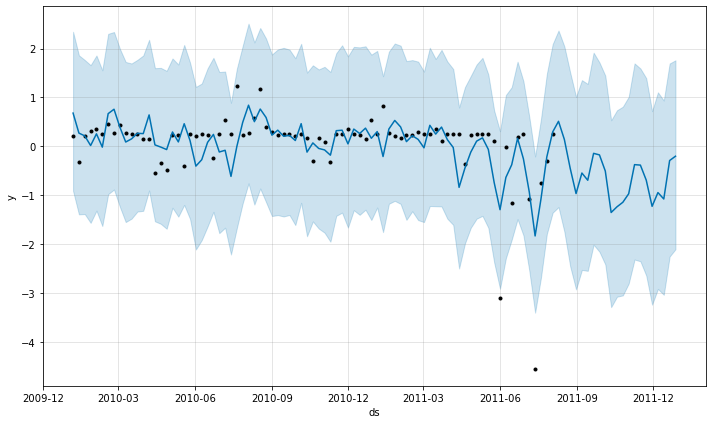

In [15]:
yhat_train = model_prophet_train.plot(forecast_train) #mcmc sampling=1000

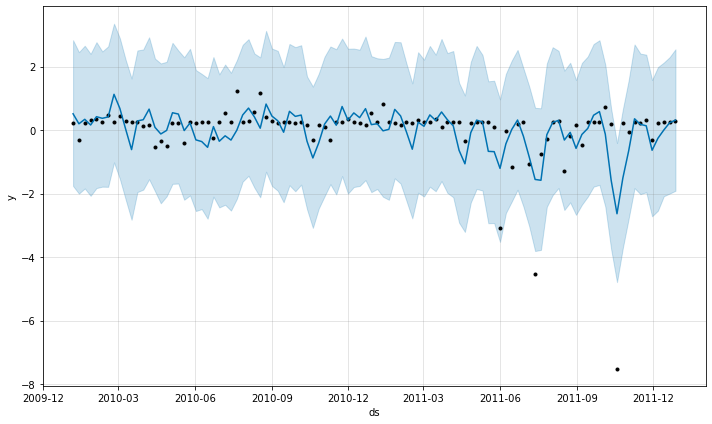

In [16]:
yhat_GT = model_prophet_GT.plot(forecast_GT) #mcmc sampling=1000

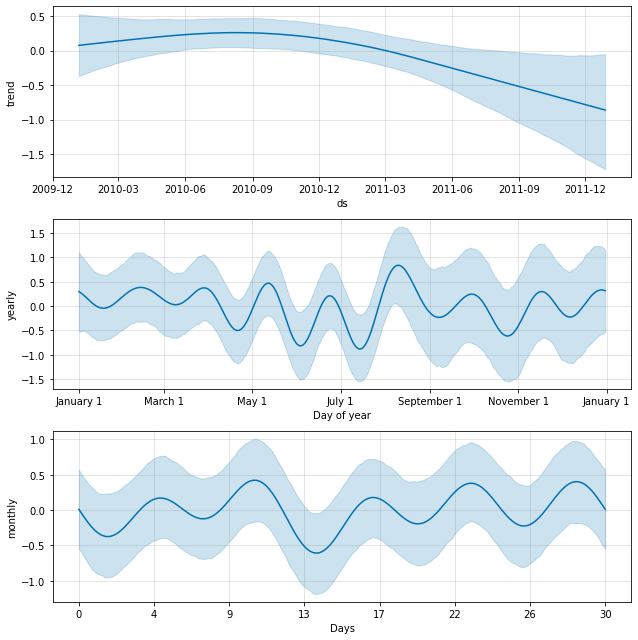

In [17]:
fig_train_seasonality = model_prophet_train.plot_components(forecast_train)

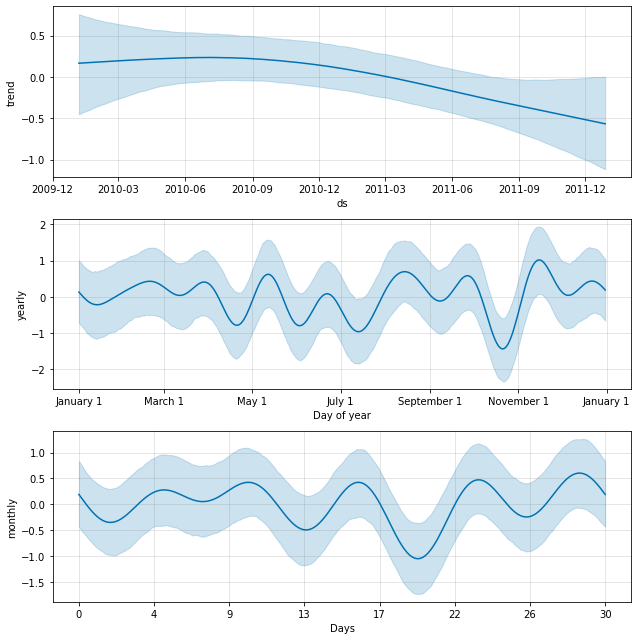

In [18]:
fig_GT_seasonality = model_prophet_GT.plot_components(forecast_GT)

I have checked if there is a clear trend and seasonality with multiple identifiers, but none of them shows any visible patterns. Otherwise, I would use Bayesian infernece with prior and posterior samplings in pymc package. It provides the uncertainty level and it is always good to have stochastic results in time-series forecasting tasks.

Unfortunately, I do not find any seasonality patterns, so just start creating the training and test dataset without seasonality.

The model I choose is a random forest regression model in this case study.

In [19]:
temp1 = data_single.drop(['date','identifier', 'market_cap', 'sector', 'index_membership', 'target'], axis = 1)
temp1.head()

,factor_1,factor_2,factor_3,factor_4,factor_5,factor_6,factor_7,factor_8,factor_9,factor_10,target_standardized
0,0.810892,-0.000313,0.793692,0.694682,0.319044,0.836105,0.953460,0.992466,-0.000041,0.243071,0.209497
1,0.180231,-0.008742,0.771631,0.213238,0.899968,0.424931,0.769680,0.697534,-0.002863,0.328375,-0.314298
2,0.248783,-0.000395,0.266502,0.400938,0.740548,0.072397,0.330282,0.922043,-0.000494,0.632542,0.217902
3,0.232442,0.000106,0.602668,0.410034,0.402635,0.626763,0.431710,0.335060,0.000004,0.527852,0.311280
4,0.508556,0.000002,0.458952,0.457596,0.739274,0.045372,0.338007,0.581852,0.001139,0.265988,0.346501


Standardize the features as well, it is generally more robust again outliers than the normalization.

In [20]:
temp1 = (temp1-temp1.mean()) / temp1.std()
temp1

,factor_1,factor_2,factor_3,factor_4,factor_5,factor_6,factor_7,factor_8,factor_9,factor_10,target_standardized
0,1.005428,0.135907,1.024208,0.798619,-0.773265,1.270721,1.688618,1.847240,0.190593,-0.759395,0.209497
1,-1.100850,-2.172781,0.940403,-0.900616,1.257738,-0.119142,1.001600,0.816271,-0.041496,-0.478129,-0.314298
2,-0.871903,0.113588,-0.978559,-0.238136,0.700380,-1.310790,-0.640996,1.601069,0.153345,0.524786,0.217902
3,-0.926478,0.250786,0.298519,-0.206031,-0.481015,0.563097,-0.261830,-0.450798,0.194280,0.179597,0.311280
4,-0.004313,0.222213,-0.247450,-0.038163,0.695927,-1.402140,-0.612121,0.411892,0.287652,-0.683833,0.346501
...,...,...,...,...,...,...,...,...,...,...,...
99,1.478161,-0.433548,1.793272,0.393102,-0.818689,1.251621,-0.387884,-1.307642,-0.285106,-1.153851,-0.325832
100,-0.206969,-0.117668,0.952994,1.086523,1.117733,0.042586,0.786918,1.811661,0.084891,-1.350853,0.223756
101,-1.646150,0.222080,1.453176,1.702823,1.344565,-0.184382,0.175220,-0.626373,0.194034,0.102071,0.248743
102,0.070080,0.223524,1.275669,0.895494,-0.134507,1.247015,0.121602,-1.346863,0.194647,-0.979221,0.249808


Since the amount of each identifier is not huge, I decided to grid-search to find the optimum hyperparameters.

In [21]:
X = temp1[['factor_1', 'factor_2', 'factor_3', 'factor_4', 'factor_5', 'factor_6', 'factor_7', 'factor_8', 'factor_9', 'factor_10']]
y = temp1['target_standardized']

# Split dataset into training set (abour 80%) and test set (about 20%
X_train = X[:math.floor(0.8 * len(X))]
X_test = X[math.floor(0.8 * len(X)):]
y_train = y[:math.floor(0.8 * len(X))]
y_test = y[math.floor(0.8 * len(X)):]

grid = { 
    'n_estimators': [200,300,400,500],
    'max_features': ['auto','sqrt','log2'],
    'max_depth' : [5,10,15,20],
    'random_state' : [18]
}

grid_rfr = GridSearchCV(estimator=RandomForestRegressor(), param_grid=grid, cv= 5)
grid_rfr.fit(X_train, y_train)
grid_rfr.best_params_

{'max_depth': 10,
 'max_features': 'sqrt',
 'n_estimators': 300,
 'random_state': 18}

In [22]:
model_chosen = RandomForestRegressor(
    n_estimators = grid_rfr.best_params_['n_estimators'],
    max_features = grid_rfr.best_params_['max_features'],
    max_depth = grid_rfr.best_params_['max_depth'],
    random_state = 18
)

In [23]:
model_chosen.fit(X_train, y_train) 

RandomForestRegressor(max_depth=10, max_features='sqrt', n_estimators=300,
                      random_state=18)

In [24]:
y_prediction = model_chosen.predict(X_test)
# Compute mean squared error
mse = mean_squared_error(y_test, y_prediction)
mse

1.793928937537279

The default loss function of RandomForestRegressor in scikit-learn package is the sqared error.
This may be customized for different purpose.

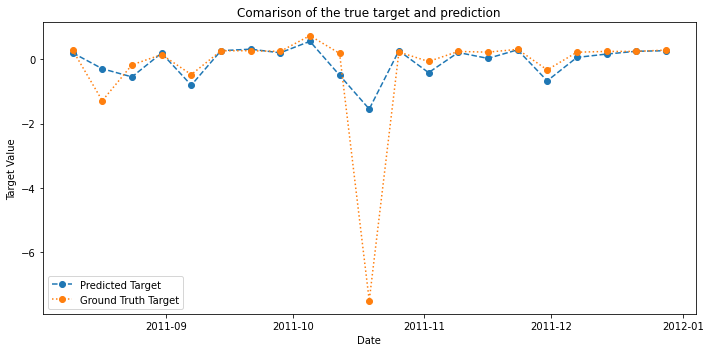

In [25]:
plt.rcParams["figure.figsize"] = [10, 5]
plt.rcParams["figure.autolayout"] = True

fig, ax = plt.subplots()

ax.plot_date(data_prophet_test['ds'], y_prediction, 'o--', label='Predicted Target')
ax.plot_date(data_prophet_test['ds'], y_test, 'o:', label='Ground Truth Target')
plt.title('Comarison of the true target and prediction')
plt.xlabel('Date')
plt.ylabel('Target Value')
plt.legend()

From several experiments with the different identifiers, I have noticed that the regression model perform quite well. However, it does not find the outliers, which significantly increases the MSE.